In [2]:
import os
os.chdir('../')
%pwd

'D:\\projects\\Project-GAN-AnimeFaces'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainModelConfig:
    root_dir: Path
    generator_model: Path
    discriminator_model: Path
    image_source: Path
    latent_size: int
    image_size: int
    batch_size: int

In [4]:
from AnimeFaces.constants import * 
from AnimeFaces.utils.common import read_yaml, create_directories

In [5]:
class ConfigurationManager:
    def __init__(self , config_filepath = CONFIG_FILE_PATH , params_filepath = PARAMS_FILE_PATH , schema_filepath = SCHEMA_FILE_PATH,):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])

    def get_train_model_config(self) -> TrainModelConfig:
        config = self.config.train_model
        create_directories([config.root_dir])
        train_model_config = TrainModelConfig(
            root_dir = config.root_dir,
            generator_model = config.generator_model,
            discriminator_model = config.discriminator_model,
            image_source = config.image_source,
            latent_size = config.latent_size,
            image_size = config.image_size,
            batch_size = config.batch_size,
        )
        return train_model_config

In [8]:
from AnimeFaces import logger
from AnimeFaces.utils.device_utils import get_default_device, DeviceDataLoader, to_device
from AnimeFaces.utils.image_utils import show_batch
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
import pickle
from AnimeFaces.entity.discriminator_model import Discriminator
from AnimeFaces.entity.generator_model import Generator
from tqdm.notebook import tqdm
import torch.nn.functional as F

class TrainModel:
    def __init__(self, config: TrainModelConfig, device='cuda'):
        self.config = config
        self.device = get_default_device()
        self.generator = Generator(self.config.latent_size)
        self.generator.load_state_dict(torch.load(self.config.generator_model))
        self.discriminator = Discriminator()
        self.discriminator.load_state_dict(torch.load(self.config.discriminator_model))

    def load_models(self):
        self.generator = Generator(self.config.latent_size)
        self.generator.load_state_dict(torch.load(self.config.generator_model))
        self.generator = to_device(self.generator, self.device)
        self.discriminator = Discriminator()
        self.discriminator.load_state_dict(torch.load(self.config.discriminator_model))
        self.discriminator = to_device(self.discriminator, self.device)
        logger.info(f"Generator And Discriminator Model Loaded")

    
    def load_and_transform_data(self):
        DATA_DIR = self.config.image_source
        image_size = self.config.image_size
        batch_size = self.config.batch_size
        stats = (0.5,0.5,0.5),(0.5,0.5,0.5)
        train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
            T.Resize(image_size),
            T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(*stats)
        ]))
        train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=2, pin_memory=True)
        self.train_dl = DeviceDataLoader(train_dl,self.device)
        show_batch(self.train_dl, self.config.root_dir)
        logger.info(f"Data Loaded to: {self.device} and saved to: {self.config.root_dir}")

    def train_discriminator(self,real_images,opt_d):
    
      opt_d.zero_grad()
    
      real_preds = self.discriminator(real_images)
      real_targets = torch.ones(real_images.size(0),1,device=self.device)
      real_loss = F.binary_cross_entropy(real_preds,real_targets)
      real_score = torch.mean(real_preds).item()
    
      latent = torch.randn(self.config.batch_size,self.config.latent_size,1,1,device=self.device)
      fake_images = self.generator(latent)
    
      fake_targets = torch.zeros(fake_images.size(0),1,device=self.device)
      fake_preds = self.discriminator(fake_images)
      fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
      fake_score = torch.mean(fake_preds).item()
    
      loss = real_loss + fake_loss
      loss.backward()
      opt_d.step()
      return loss.item, real_score, fake_score

    def train_generator(self,opt_g):
      opt_g.zero_grad()
    
      latent = torch.randn(self.config.batch_size,self.config.latent_size,1,1,device=self.device)
      fake_images = self.generator(latent)
    
      preds = self.discriminator(fake_images)
      targets = torch.ones(self.config.batch_size,1,device=self.device)
      loss = F.binary_cross_entropy(preds,targets)
    
      loss.backward()
      opt_g.step()
    
      return loss.item()

    def fit(self,epochs,lr,start_idx=1):
      torch.cuda.empty_cache()
    
      losses_g=[]
      losses_d=[]
      real_scores = []
      fake_scores = []
    
      opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr,betas=(0.5,0.999))
      opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr,betas=(0.5,0.999))
    
      for epoch in range(epochs):
        for real_images,_ in tqdm(self.train_dl):
          loss_d , real_score , fake_score = self.train_discriminator(real_images,opt_d)
          loss_g = self.train_generator(opt_g)
    
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
    
        logger.info("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        save_samples(epoch+start_idx,fixed_latent)
      return losses_g, losses_d, real_scores,fake_scores
    

[2023-10-02 17:05:11,151: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-10-02 17:05:11,154: INFO: common: yaml file: params.yaml loaded successfully]
[2023-10-02 17:05:11,156: INFO: common: yaml file: schema.yaml loaded successfully]
[2023-10-02 17:05:11,157: INFO: common: Directory Created: artifacts]
[2023-10-02 17:05:11,158: INFO: common: Directory Created: artifacts/train_model]
[2023-10-02 17:05:11,303: INFO: 441105437: Generator And Discriminator Model Loaded]
[2023-10-02 17:05:19,068: INFO: image_utils: Sample Generated Images Saved: artifacts/train_model\loaded-images-0001.png]


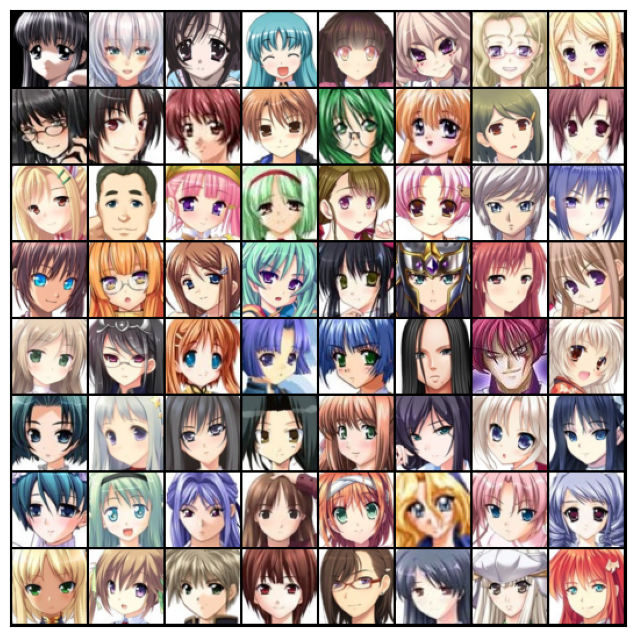

[2023-10-02 17:05:20,658: INFO: 441105437: Data Loaded to: cpu and saved to: artifacts/train_model]


  0%|          | 0/994 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
%matplotlib inline
try:
    config = ConfigurationManager()
    train_model_config = config.get_train_model_config()
    train_model = TrainModel(config = train_model_config)
    train_model.load_models()
    train_model.load_and_transform_data()
    # history = train_model.fit(50,0.002)
    train_model.save_model
except Exception as e:
    raise e